In [292]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, GRU, Dense, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [293]:
# Data

warnings.filterwarnings("ignore")

tsla_data = yf.download("TSLA", start="2022-01-01", end="2025-01-01", progress=False)
sp_data = yf.download("^GSPC", start="2022-01-01", end="2025-01-01", progress=False)

tsla_data = tsla_data[[('Close', 'TSLA')]]
sp_data = sp_data[[('Close', '^GSPC')]]

tsla_data.columns = ['Close']
sp_data.columns = ['Close']

tsla_data.fillna(method='ffill', inplace=True)
sp_data.fillna(method='ffill', inplace=True)

df = tsla_data.merge(sp_data, left_index=True, right_index=True, how='inner')
df.columns = ['Tsla','Sp']

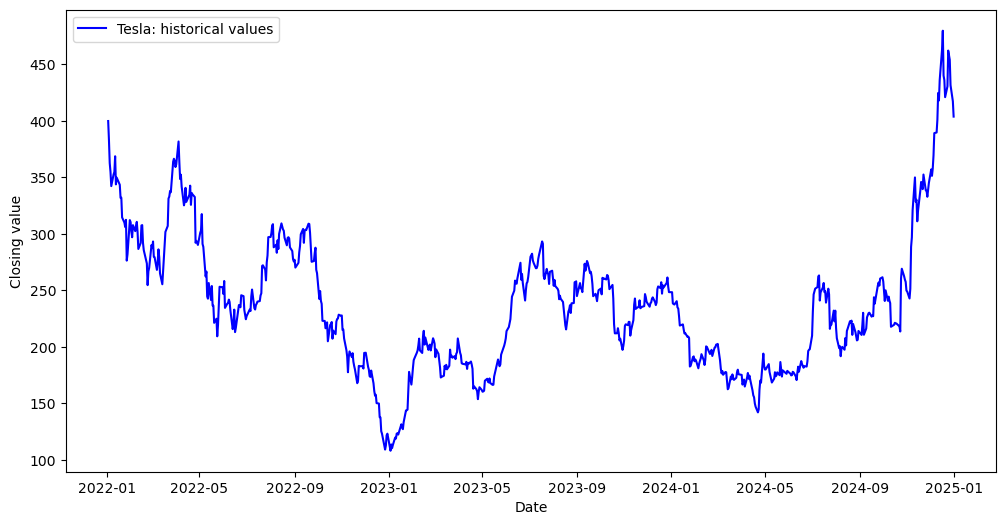

In [294]:
# Initial plots

plt.figure(figsize=(12,6))
plt.plot(df['Tsla'], label="Tesla: historical values", color="blue")
plt.xlabel("Date")
plt.ylabel("Closing value")
plt.legend()
plt.show()

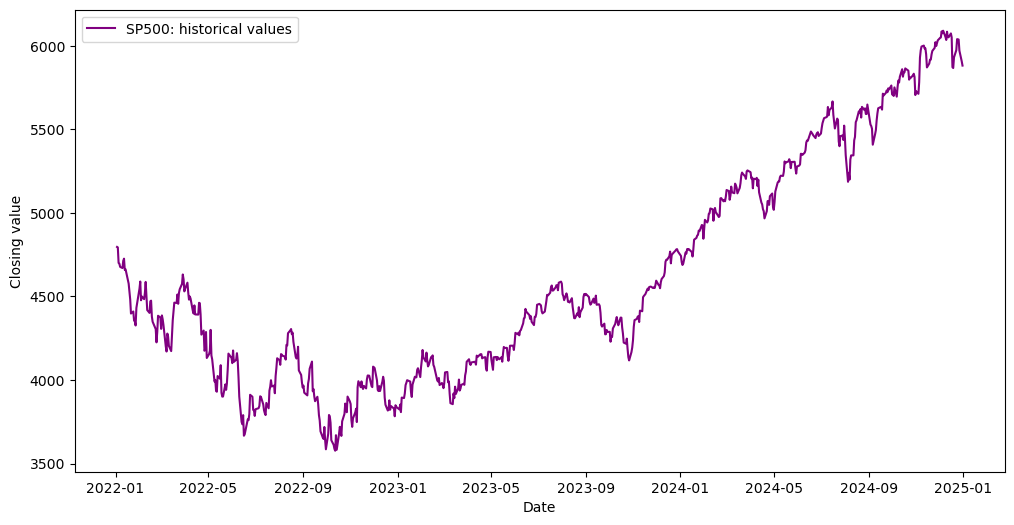

In [295]:
plt.figure(figsize=(12,6))
plt.plot(df['Sp'], label="SP500: historical values", color="purple")
plt.xlabel("Date")
plt.ylabel("Closing value")
plt.legend()
plt.show()

In [296]:
# Preparing data for NNs

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df)
df['Sp_scaled'] = scaled_values[:,0]
df['Tsla_scaled'] = scaled_values[:,1]

sequence_length = 30

def create_sequences(data, seq_length):

    sequences = []
    targets = []

    for i in range(len(data)-seq_length):
        sequences.append(data[i:i+seq_length, :])
        targets.append(data[i+seq_length, 0])

    return np.array(sequences), np.array(targets)

X, y = create_sequences(df[['Tsla_scaled', 'Sp_scaled']].values ,
                        sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape)

(578, 30, 2)


In [297]:
# Define models

warnings.filterwarnings("ignore")

def lstm_model(input_shape):

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss="mean_squared_error")
    return model

def gru_model(input_shape):

    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(64, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss="mean_squared_error")
    return model
def cnn_lstm_model(input_shape):
    model = Sequential([

        # CNN Feature Extraction
        Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        LSTM(50, return_sequences=False),
        Dropout(0.2),
        
        Dense(25, activation="relu"),
        Dense(1) 
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss="mean_squared_error")
    return model

lstm = lstm_model((X_train.shape[1],X_train.shape[2]))
gru = gru_model((X_train.shape[1],X_train.shape[2]))
cnn_lstm = cnn_lstm_model((X_train.shape[1],X_train.shape[2]))

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
epochs = 50

lstm.summary()
gru.summary()
cnn_lstm.summary()


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_82 (LSTM)                  │ (None, 30, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_83 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,827 (202.45 KB)

 Trainable params: 51,827 (202.45 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_52 (GRU)                    │ (None, 30, 64)         │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_53 (GRU)                    │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,667 (154.95 KB)

 Trainable params: 39,667 (154.95 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_19 (Conv1D)              │ (None, 26, 128)        │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_84 (LSTM)                  │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,509 (150.43 KB)

 Trainable params: 38,509 (150.43 KB)

 Non-trainable params: 0 (0.00 B)

In [298]:
# Training lstm

history_lstm = lstm.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                        validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0406 - val_loss: 0.0019
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0057 - val_loss: 0.0015
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0028 - val_loss: 0.0051
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0024 - val_loss: 0.0096
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0023 - val_loss: 0.0088
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0

In [299]:
# Training gru

history_gru = gru.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                      validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0507 - val_loss: 0.0611
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0015 - val_loss: 0.0076
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0

In [300]:
# Training cnn_lstm

history_cnn_lstm = cnn_lstm.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                                validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/50


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0615 - val_loss: 0.0910
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0081 - val_loss: 0.0059
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047 - val_loss: 0.0062
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025 - val_loss: 0.0080
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0080
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_l

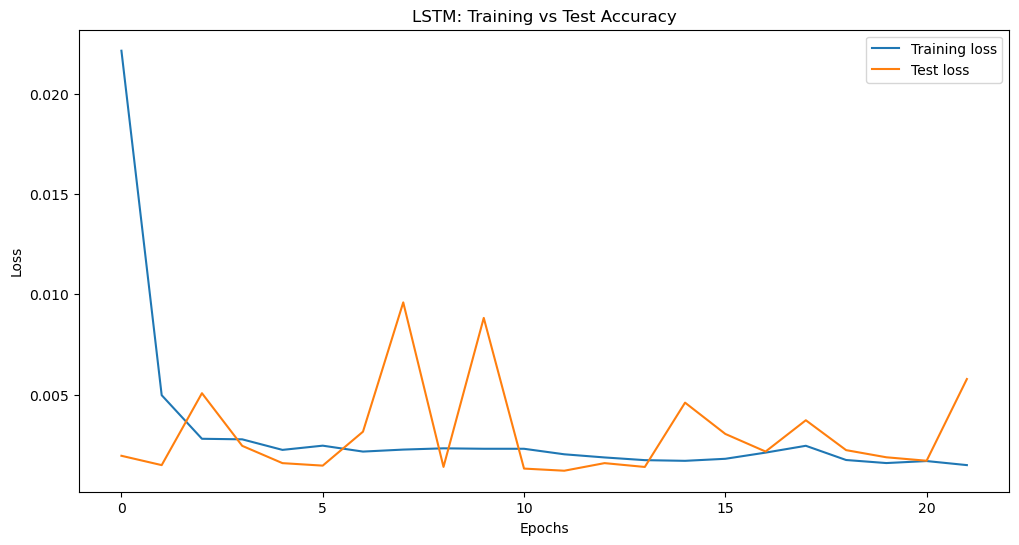

In [301]:
plt.figure(figsize=(12,6))
plt.plot(history_lstm.history['loss'], label="Training loss")
plt.plot(history_lstm.history['val_loss'], label = "Test loss")
plt.legend()
plt.title("LSTM: Training vs Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

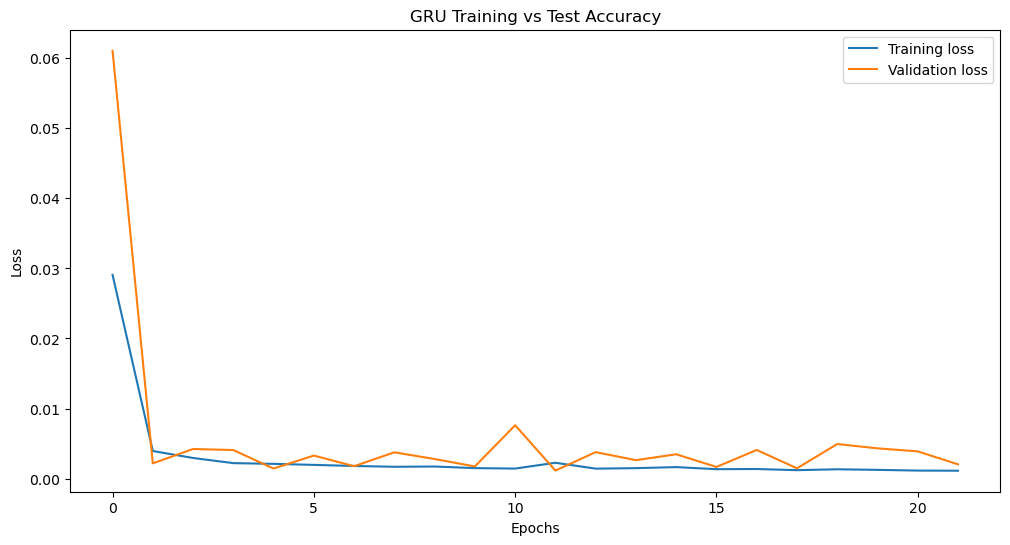

In [302]:
plt.figure(figsize=(12,6))
plt.plot(history_gru.history['loss'], label = "Training loss")
plt.plot(history_gru.history['val_loss'], label = "Validation loss")
plt.legend()
plt.title("GRU Training vs Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


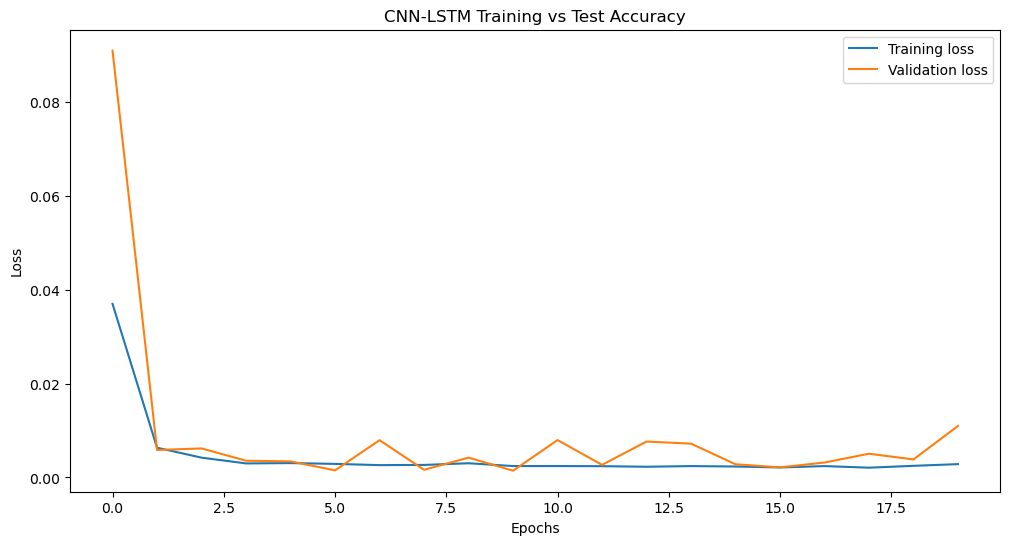

In [303]:
plt.figure(figsize=(12,6))
plt.plot(history_cnn_lstm.history['loss'], label = "Training loss")
plt.plot(history_cnn_lstm.history['val_loss'], label = "Validation loss")
plt.legend()
plt.title("CNN-LSTM Training vs Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


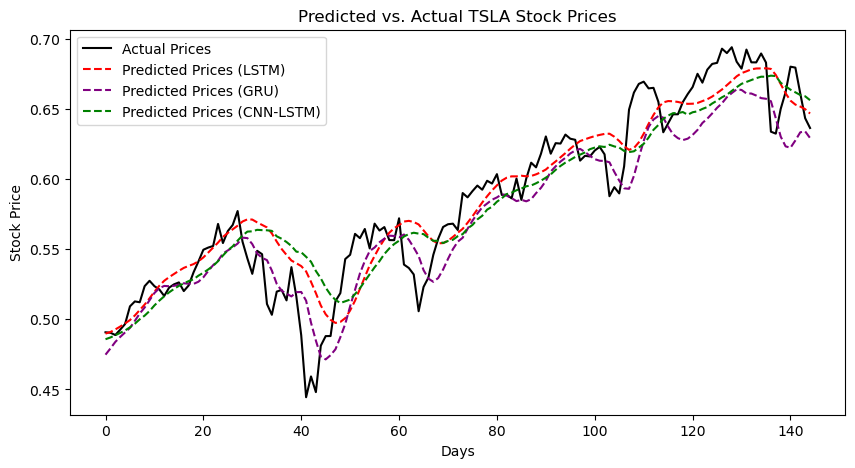

In [304]:
# Get model predictions on the test set

y_pred_lstm = lstm.predict(X_test)
y_pred_gru = gru.predict(X_test)
y_pred_cnn_lstm = cnn_lstm.predict(X_test)

# Scale data back to original range

scaler.fit(y_train.reshape(-1, 1))
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm)
y_pred_gru_rescaled = scaler.inverse_transform(y_pred_gru)
y_pred_cnn_lstm_rescaled = scaler.inverse_transform(y_pred_cnn_lstm) 
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)) 

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label="Actual Prices", color="black")
plt.plot(y_pred_lstm_rescaled, label="Predicted Prices (LSTM)", color="red", linestyle="dashed")
plt.plot(y_pred_gru_rescaled, label="Predicted Prices (GRU)", color="purple", linestyle="dashed")
plt.plot(y_pred_cnn_lstm_rescaled, label="Predicted Prices (CNN-LSTM)", color="green", linestyle="dashed")
plt.legend()
plt.title("Predicted vs. Actual TSLA Stock Prices")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.show()